In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
import matplotlib.ticker as ticker
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *
np.random.seed(constants.SEEDS[3])


In [2]:

nrows = 30
num_bins = 15
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
#experiment_name = f"RiverSwim{nS}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='mlflow-artifacts:/522434938928571024', creation_time=1717491015797, experiment_id='522434938928571024', last_update_time=1717491015797, lifecycle_stage='active', name='FrozenLake_30x30_15', tags={}>

In [3]:
results = get_parent_artifacts(experiment_id=experiment_id)

[<Run: data=<RunData: metrics={}, params={}, tags={'batch_size': '32',
 'change_map': 'False',
 'checkpoint_step': '500',
 'dense_reward': 'True',
 'episodes': '8900000',
 'epochs': '4',
 'eps_model': '0.0',
 'eps_ppo': '0.2',
 'final_temp': '1',
 'gamma': '0.999',
 'goal_reward': '1.0',
 'lam': '1',
 'mlflow.runName': 'PPO_15',
 'mlflow.source.name': 'c:\\Users\\crist\\OneDrive - Politecnico di '
                       'Milano\\Polimi\\Tesi\\TMDP\\env_mlflow\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'crist',
 'model_lr': '0.18333753662151184',
 'pol_lr': '0.06921429610818511',
 'reward_shape': 'True',
 'seed': '12715',
 'shape_range': '(-1, 0)',
 'tau': '0.0',
 'temp': '112.98985548008592',
 'test_episodes': '1000'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/522434938928571024/d41b5de3d6b541b393305c0db6fc7be9/artifacts', end_time=1717892223730, experiment_id='522434938928571024', lifecycle_stage='active', run_id='d41b5de3d6b541b

Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmp68yv_0fj\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=4335584, is_dir=False, path='results.pth'>, <FileInfo: file_size=38658, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpgz680w5k\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=4268384, is_dir=False, path='results.pth'>, <FileInfo: file_size=38022, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpk7ny8v16\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=5268960, is_dir=False, path='results.pth'>, <FileInfo: file_size=38596, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpb3cmy8pg\results.pth
Dictionary loaded from MLflow
[<FileInfo: file_size=7587744, is_dir=False, path='results.pth'>, <FileInfo: file_size=52539, is_dir=False, path='reward_image.png'>]


Dictionary loaded from C:\Users\crist\AppData\Local\Temp\tmpuya_0fsi\results.pth
Dictionary loaded from MLflow


In [4]:
results = sorted(results, key=lambda x: x["label"])

In [5]:
"""results[1]["label"] = '2'"""

'results[1]["label"] = \'2\''

In [6]:
print(results[2].keys())

dict_keys(['tests_returns', 'tests_lens', 'num_runs', 'change_map', 'num_bins', 'label', 'checkpoint_step'])


In [7]:
def plot_experiment_results(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False, x_scale:int=500, 
                            x_len_ticks:int=2, log_scale:bool=False, 
                            moving_avg_window:int=1, ci_ma:int=1,
                            ):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    optimal = None
    rew = [r["tests_returns"] for r in results]
    reduced_len = np.min([len(r[0]) for r in rew])
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)

    title = "Average Return" if title is None else title
    for i, result in enumerate(results):
        rewards = result["tests_returns"]
        label = result["label"]
        if "CurrQ" in label:
            optimal = rewards[0][-1]
        avg_rewards = np.mean(rewards, axis=0)
        if reduce:
            avg_rewards = avg_rewards[:reduced_len]
        
        # Calculate moving average
        if moving_avg_window > 1:
            avg_rewards = pd.Series(avg_rewards).rolling(window=moving_avg_window, min_periods=1).mean().values

        current_x_scale = x_scale if not "checkpoint_step" in result else result["checkpoint_step"]
        x_values = np.arange(len(avg_rewards)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_rewards, label=label, c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_rewards, label=label, c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        
        if conf_int:
            std_dev = np.std(rewards, axis=0)
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(rewards)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_rewards + ci * std_err
            lower_bound = avg_rewards - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    if optimal is not None:
        optimal_label = 'Optimal'
        ax.axhline(y=optimal, color=COLORS_DICT[optimal_label], 
                   linestyle=LINE_STYLES_DICT[optimal_label], 
                   label=optimal_label)
        ax.set_yticks(adjust_y_ticks(ax, optimal))
    
    length = max_len if not reduce else reduced_len
    length = length * x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        labels = generate_M_labels(length, x_len_ticks)  # Make sure this function is defined elsewhere
        plt.xticks(np.linspace(0, length, x_len_ticks), labels)
        
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Average Return')
    plt.show()
    return fig

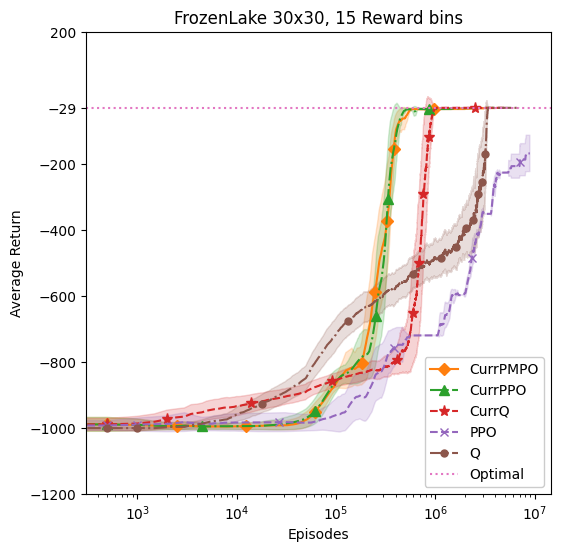

In [8]:
parts = experiment_name.split("_")
if len(parts) == 3:
    title = f"{parts[0]} {parts[1]}, {parts[2]} Reward bins"
    if parts[2] == "0":
        title = f"{parts[0]} {parts[1]}"

else:
    title = f"{parts[0]} {parts[1]}"
fig = plot_experiment_results(results, reduce=False, conf_int=True, 
                              x_len_ticks=4, title=title,
                              log_scale=True, moving_avg_window=100,)


In [9]:
def plot_experiment_len(results, title=None, figsize=(6, 6), 
                            reduce:bool=False, extend:bool=False,
                            conf_int:bool=False, x_scale:int=500, 
                            x_len_ticks:int=2, log_scale:bool=False, 
                            ci_ma:int=1, moving_avg_window:int=1,
                            sample_step:int=1,):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    optimal = None
    rew = [r["tests_returns"] for r in results]
    reduced_len = np.min([len(r[0]) for r in rew])
    max_len = np.max([len(r[0]) for r in rew])
    fig, ax = plt.subplots(figsize=figsize)
    
    title = "Average Episode Length" if title is None else title
    for i, result in enumerate(results):
        if result.get("tests_lens") is None:
            continue
        tests_lens = result["tests_lens"]
        label = result["label"]
        if label == "PPO":
            continue
        optimal = 2*nrows-2
        avg_tests_lens = np.mean(tests_lens, axis=0)[::sample_step]
        if reduce:
            avg_tests_lens = avg_tests_lens[:reduced_len]
        
        current_x_scale = x_scale if not "checkpoint_step" in result else result["checkpoint_step"]
        x_values = np.arange(len(avg_tests_lens)) * current_x_scale*sample_step
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, avg_tests_lens, label=label, c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, avg_tests_lens, label=label, c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        
        if conf_int:
            std_dev = np.std(tests_lens, axis=0)[::sample_step]
            if reduce:
                std_dev = std_dev[:reduced_len]
            
            n_samples = len(tests_lens)
            if moving_avg_window > 1:
                std_dev = pd.Series(std_dev).rolling(window=moving_avg_window, min_periods=1).mean().values
            std_err = std_dev / np.sqrt(n_samples)
            ci = 1.96
            upper_bound = avg_tests_lens + ci * std_err
            lower_bound = avg_tests_lens - ci * std_err
            plt.fill_between(x_values, lower_bound, upper_bound, color=COLORS_DICT[label], alpha=0.2)
    
    if optimal is not None:
        optimal_label = 'Optimal'
        ax.axhline(y=optimal, color=COLORS_DICT[optimal_label], 
                   linestyle=LINE_STYLES_DICT[optimal_label], 
                   label=optimal_label)
        ax.set_yticks(adjust_y_ticks(ax, optimal))
    
    length = max_len if not reduce else reduced_len
    length = length * x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        labels = generate_M_labels(length, x_len_ticks)  # Make sure this function is defined elsewhere
        plt.xticks(np.linspace(0, length, x_len_ticks), labels)
        
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Episode Length')
    plt.show()
    return fig

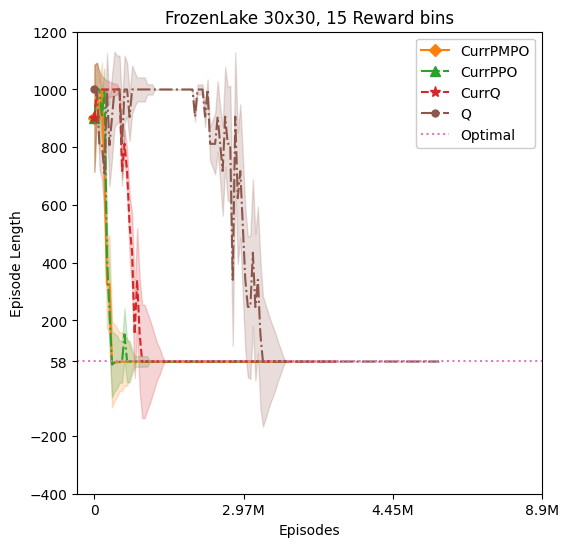

In [10]:
fig = plot_experiment_len(results, reduce=False, 
                              x_len_ticks=4, title=title,
                              log_scale=False, conf_int=True, 
                              moving_avg_window=10, sample_step=100)

In [11]:
def plot_experiment_taus(results, title=None, figsize=(6, 6), 
                            x_len_ticks:int=2, log_scale:bool=False,):
    assert x_len_ticks >= 2, "Error: x_len_ticks must be >= than 2" 
    plt.close('all')
    
    fig, ax = plt.subplots(figsize=figsize)
    
    rew = [len(r["taus"]) for r in results if r.get("taus") is not None]
    max_len = np.max(rew)

    title = "Average Taus" if title is None else title
    for i, result in enumerate(results):
        if result.get("taus") is None:
            continue
        taus = result["taus"]
        label = result["label"]
        current_x_scale = result["checkpoint_step"]
        x_values = np.arange(len(taus)) * current_x_scale
        
        if log_scale:
            ax.set_xscale('log')
            ax.plot(x_values, taus, label=label, c=COLORS_DICT[label], 
                    linestyle=LINE_STYLES_DICT[label],
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_LOG_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
        else:
            ax.plot(x_values, taus, label=label, c=COLORS_DICT[label],
                    linestyle=LINE_STYLES_DICT[label], 
                    marker = MARKERS_DICT[label],
                    markevery=MARKER_FREQUENCY_DICT[label],
                    markersize=MARKER_SIZE_DICT[label],
                    )
    
    max_len = max_len * current_x_scale
    ax.legend(loc="best", framealpha=1.)
    ax.set_title(title)
    if not log_scale:
        labels = generate_M_labels(max_len, x_len_ticks)  # Make sure this function is defined elsewhere
        plt.xticks(np.linspace(0, max_len, x_len_ticks), labels)
        
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Tau')
    plt.show()
    return fig

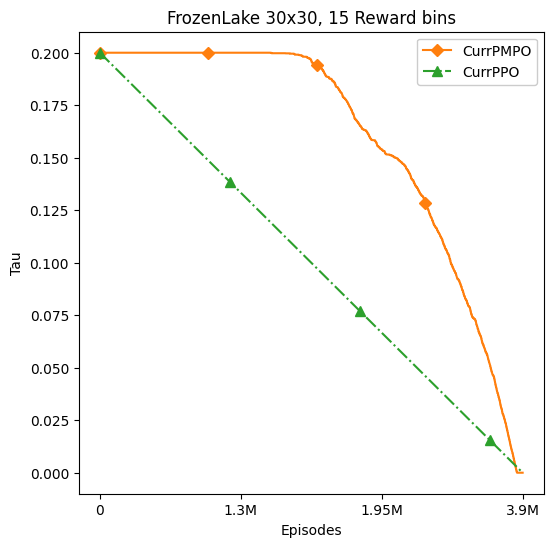

In [12]:
fig = plot_experiment_taus(results,x_len_ticks=4, 
                           title=title, log_scale=False)